## Extract TLD in Canvas Fingerprinting scripts

This notebook extracts the TLDs in Canvas Fingerprinting scripts. The heuristics to find out the Canvas Fingerprinting scripts is directly taken from [2019_03_willougr_fingerprinting_implementation_sixth_sense/Canvas Fingerprinting Heuristics](https://github.com/mozilla/overscripted/blob/master/analyses/2019_03_willougr_fingerprinting_implementation_sixth_sense/Canvas%20Fingerprinting%20Heuristics.ipynb).

In [1]:
import dask.dataframe as dd
import os
import re
import json

from dask.distributed import Client, progress
from pandas.api.types import CategoricalDtype

DATA_DIR = 'YOUR DATA DIRECTORY HERE'
DATA_DIR_FULL ='/home/soumya/Dataset/sample_0.parquet'

/home/soumya/.conda/envs/overscripted/lib/python3.6/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/home/soumya/.conda/envs/overscripted/lib/python3.6/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [2]:
Client()

/home/soumya/.conda/envs/overscripted/lib/python3.6/site-packages/distributed/bokeh/core.py:57: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn('\n' + msg)


Client Scheduler: tcp://127.0.0.1:35107 Dashboard: http://127.0.0.1:42203/status,Cluster Workers: 4 Cores: 12 Memory: 8.25 GB


# Build candidates

In [3]:
df_to_data_urls_df = dd.read_parquet(DATA_DIR_FULL, columns=['script_url', 'symbol'])
df_to_data_urls_df = df_to_data_urls_df[df_to_data_urls_df.symbol == 'HTMLCanvasElement.toDataURL']
to_data_urls = df_to_data_urls_df.script_url.unique().compute()
to_data_urls[0:5]

/home/soumya/.local/lib/python3.6/site-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


0     https://www.coches.net/ztkieflaaxcvaiwh121837.js
1      http://static.mvideo.ru/media/js/mvideo.js?v0.7
2        https://misc.gomein.net.cn/js/regfront/gfp.js
3         http://www.elcorteingles.es/akam/10/240f2be0
4    https://player.mais.uol.com.br/js/uolplayer.mi...
Name: script_url, dtype: object

In [4]:
def large_enough(row):
    width = float(row.argument_2)
    height = float(row.argument_3)
    return width >= 16 and height >= 16

df_get_image_data_df = dd.read_parquet(DATA_DIR_FULL, columns=['script_url', 'symbol', 'argument_2', 'argument_3'])
df_get_image_data_df = df_get_image_data_df[df_get_image_data_df.symbol == 'CanvasRenderingContext2D.getImageData']
df_get_image_data_df = df_get_image_data_df[df_get_image_data_df.apply(large_enough, axis=1, meta=('bool'))]
get_image_data_urls = df_get_image_data_df.script_url.unique().compute()
get_image_data_urls[0:5]

0    http://ue.17173cdn.com/a/newgame/index/2017/v3...
1                       resource://pdf.js/build/pdf.js
2           http://cdn.promodj.com/core/core.js?1ce4f0
3    https://s0.2mdn.net/ads/studio/cached_libs/cre...
4    https://www.youtube.com/yts/jsbin/player-vflyo...
Name: script_url, dtype: object

In [5]:
print('n to_data_urls', len(to_data_urls))
print('n get_image_data_urls', len(get_image_data_urls))
candidate_urls = to_data_urls.append(get_image_data_urls).unique()
print('n candidate urls', len(candidate_urls))

n to_data_urls 3441
n get_image_data_urls 95
n candidate urls 3530


In [6]:
all_candidate_urls = candidate_urls.copy()

# Start removing

## 1. Remove manually filtered

In [7]:
false_positive_script_urls = {
    'http://www.fivola.com/',
    'http://cdn02.centraledachats.be/dist/js/holder.js',
    'http://ccmedia.fr/accueil.php',
    'http://rozup.ir/up/moisrex/themes/space_theme/script.js'
}

In [8]:
candidate_urls = [url for url in candidate_urls if url not in false_positive_script_urls]
print('n candidate urls', len(candidate_urls))

n candidate urls 3530


In [9]:
print(len(set(all_candidate_urls) - set(candidate_urls)))
disgarded_urls = [url for url in all_candidate_urls if url not in candidate_urls]
with open('not_canvas_fingerprinting_1.json', 'w') as f:
    f.write(json.dumps(disgarded_urls)) 

0


## 2. Remove save, restore, addEventListener

In [10]:
df_valid_calls_df = dd.read_parquet(DATA_DIR_FULL, columns=['script_url', 'symbol'])
df_valid_calls_df = df_valid_calls_df[df_valid_calls_df.symbol.isin(
    ['CanvasRenderingContext2D.save', 'CanvasRenderingContext2D.restore', 'HTMLCanvasElement.addEventListener']
)]
valid_calls_urls = df_valid_calls_df.script_url.unique().values.compute()
valid_calls_urls[0:5]

array(['https://s0.2mdn.net/ads/studio/cached_libs/createjs_2015.11.26_54e1c3722102182bb133912ad4442e19_min.js',
       'https://audience-x.linkstorm.net/CNST/CNST_AX17_2C03/libs/createjs-2015.11.26.min.js',
       'https://cdn4.forter.com/script.js?sn=d379f257f86d',
       'https://code.createjs.com/createjs-2015.11.26.min.js',
       'https://widget.sndcdn.com/single-sound-97ef94a-bcf2172b.js'],
      dtype=object)

In [11]:
candidate_urls = [url for url in candidate_urls if url not in valid_calls_urls]
print('n candidate urls', len(candidate_urls))

n candidate urls 3494


In [12]:
len(set(all_candidate_urls) - set(candidate_urls))

36

In [13]:
print(len(set(all_candidate_urls) - set(candidate_urls)))
disgarded_urls = [url for url in all_candidate_urls if url not in candidate_urls]
with open('not_canvas_fingerprinting_2.json', 'w') as f:
    f.write(json.dumps(disgarded_urls)) 

36


## 3. Must have written 10 or more characters

In [14]:
## Code sourced from: github.com/sensor-js/OpenWPM-mobile/blob/mobile_sensors/feature_extraction/extract_features.py

def text_length(arg_0):
    return len(arg_0.encode('ascii', 'ignore'))

In [15]:
df_write = dd.read_parquet(DATA_DIR_FULL, columns=['script_url', 'symbol', 'argument_0'])
df_write = df_write[df_write.script_url.isin(candidate_urls)]
df_write = df_write[df_write.symbol.isin(['CanvasRenderingContext2D.fillText', 'CanvasRenderingContext2D.strokeText'])]
df_write['len_arg'] = df_write.argument_0.apply(text_length, meta=('int'))
df_write = df_write[df_write.len_arg >= 10]
df_write = df_write.compute()
df_write.head()

,script_url,symbol,argument_0,len_arg
call_id,,,,
1_00022de65942197e3855f68b373c5a2710eefe66945e40063c30419f.json__269,https://www.coches.net/ztkieflaaxcvaiwh121837.js,CanvasRenderingContext2D.fillText,"Cwm fjordbank glyphs vext quiz, 😃",32
1_00022de65942197e3855f68b373c5a2710eefe66945e40063c30419f.json__272,https://www.coches.net/ztkieflaaxcvaiwh121837.js,CanvasRenderingContext2D.fillText,"Cwm fjordbank glyphs vext quiz, 😃",32
1_0004d550953191c5723947694ac872f7e277d94041ae0112ffa577fd.json__355,http://static.mvideo.ru/media/js/mvideo.js?v0.7,CanvasRenderingContext2D.fillText,sans-serif,10
1_0004d550953191c5723947694ac872f7e277d94041ae0112ffa577fd.json__360,http://static.mvideo.ru/media/js/mvideo.js?v0.7,CanvasRenderingContext2D.fillText,Abadi MT Condensed,18
1_0004d550953191c5723947694ac872f7e277d94041ae0112ffa577fd.json__361,http://static.mvideo.ru/media/js/mvideo.js?v0.7,CanvasRenderingContext2D.fillText,Abadi MT Condensed Light,24


In [16]:
too_many_write_urls = df_write.script_url.unique()
print('n "3 too long writes" urls', len(too_many_write_urls))

n "3 too long writes" urls 1473


## Apply 3

In [17]:
text_filter = set(too_many_write_urls)
candidate_urls = list(text_filter)

In [18]:
print(len(set(all_candidate_urls) - set(candidate_urls)))
disgarded_urls = [url for url in all_candidate_urls if url not in candidate_urls]
with open('not_canvas_fingerprinting_3.json', 'w') as f:
    f.write(json.dumps(disgarded_urls)) 

2057


In [19]:
with open('canvas_fingerprinting.json', 'w') as f:
    f.write(json.dumps(candidate_urls))

In [20]:
with open('not_canvas_fingerprinting.json', 'w') as f:
    f.write(json.dumps(disgarded_urls))

## Find Locations

In [21]:
with open('canvas_fingerprinting.json', 'r') as f:
    canvas_fp_urls = json.load(f)
    
print(len(canvas_fp_urls), '== 8514')

1473 == 8514


In [22]:
df = dd.read_parquet(DATA_DIR_FULL, columns=['script_url', 'location'])

In [23]:
df_locs = df[df.script_url.isin(canvas_fp_urls)]
locs = df_locs.location.unique().persist()
progress(locs, notebook=False)

In [24]:
print('# of locations that call canvas fingerprinting scripts:', len(locs))

# of locations that call canvas fingerprinting scripts: 3635


In [25]:
canvas_fp_urls

['https://yummy.consumable.com/3089/cnsmbl-audio-728x90-slider/widget/iframe.js?cb=1513392297114',
 'https://www.halifax.co.uk/akam/10/3ed7a62a',
 'https://tickets.amtrak.com/akam/10/23a0cf4c',
 'https://uon-mautic.cloud.contensis.com/mtc.js',
 'https://m.stripe.network/inner.html#url=https%3A%2F%2Fwww.premiumbeat.com%2Fartist%2Fmonorama-studio&title=Artist%20Profile%3A%20Monorama%20Studio%20-%20PremiumBeat&referrer=&muid=8ea697b5-3c37-45ba-8835-dc44049b449e&sid=b97c01a8-eeee-4087-a3ed-2c80c0b76b54&preview=false',
 'https://static.bshare.cn/js/libs/fingerprint2.min.js',
 'http://www.coupang.com/akam/10/1ebb4dc6',
 'https://www.johnlewis.com/akam/10/74b607d0',
 'https://www.easyjet.com/akam/10/77b2a78b',
 'https://login.mobile.de/_bm/async.js',
 'https://www.summitracing.com/sredstlcp.616405.js',
 'https://www.johnlewis.com/akam/10/478c7889',
 'https://www.naukrigulf.com/akam/10/332a3cdf',
 'http://canada.newark.com/akam/10/2073057b',
 'http://www.coupang.com/akam/10/19a8856f',
 'https:

## Extract TLD

In [26]:
import tldextract
opsuffix=[]
opurls=[]
for i in range(len(canvas_fp_urls)):
    opurls.append(tldextract.extract(canvas_fp_urls[i]))
    opsuffix.append(opurls[i].suffix)
print(opsuffix)

['com', 'co.uk', 'com', 'com', 'network', 'cn', 'com', 'com', 'com', 'de', 'com', 'com', 'com', 'com', 'com', 'org', 'com', 'com', 'com', 'com', 'com', 'com', 'network', 'com', 'net', 'de', 'ca', 'com', 'net', 'com', 'com', 'com', 'com', 'network', 'co.uk', 'com', 'com', 'com', 'net', 'de', 'ca', 'com', 'com', 'es', 'org', 'cn', 'network', 'com', 'net', 'jp', 'com', 'ca', 'com', 'com', 'es', 'com', 'com', 'co.uk', 'com', '', 'es', 'com', 'com', 'network', 'net', 'com', 'com', 'pl', 'es', 'ca', 'net', 'com', 'network', 'com', 'com', 'com', 'com', 'cn', 'com', 'com', 'net', 'com', 'com', 'com', 'com', 'network', 'com', 'de', 'de', 'com', 'es', 'com', 'com', 'es', 'com', 'com', 'network', 'com', 'network', 'com', 'de', 'es', 'com', 'com', 'nl', 'de', 'com', 'network', 'com', 'net', 'net', 'com', 'com', 'com', 'com', 'com', 'com', 'fr', 'com', 'net', 'com', 'network', 'com', 'com', 'network', 'co.uk', 'com', 'com', 'com', 'com', 'co.uk', 'net', 'com', 'com', 'io', 'de', 'network', 'net', '

In [27]:
len(canvas_fp_urls)

1473

## Frequency of each TLD

In [28]:
import collections
for i in range(len(opsuffix)):
    counter=collections.Counter(opsuffix)
print(counter)

Counter({'com': 851, 'network': 118, 'net': 96, 'es': 83, 'cn': 52, 'de': 44, 'ca': 36, 'co.uk': 35, 'it': 23, 'co.jp': 15, 'pl': 12, 'fr': 10, 'com.tw': 10, 'io': 8, 'ru': 8, 'com.br': 6, 'ws': 6, 'ch': 6, 'org': 5, 'in': 4, 'sexy': 4, '': 3, 'nl': 3, 'cz': 3, 'hk': 3, 'vn': 2, 'vc': 2, 'tv': 2, 're': 2, 'ly': 2, 'cc': 2, 'az': 2, 'jp': 1, 'pub': 1, 'biz': 1, 'dhl': 1, 'pro': 1, 'com.au': 1, 'st': 1, 'net.cn': 1, 'gs': 1, 'ai': 1, 'sk': 1, 'jo': 1, 'systems': 1, 'org.br': 1, 'co.il': 1})


In [29]:
len(counter)

47

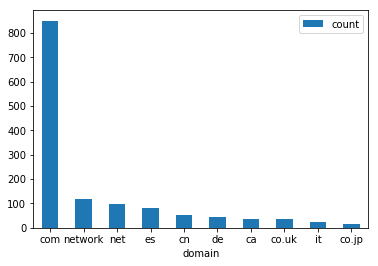

In [2]:
import pandas as pd
dfplot = pd.DataFrame({'domain':['com','network','net','es', 'cn','de','ca','co.uk','it','co.jp'], 'count':[851,118,96,83,52,44,36,35,23,15]})
ax = dfplot.plot.bar(x='domain', y='count', rot=0)